In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, random_state=0):
    
    np.random.seed(random_state)
    x = np.zeros((datanum, 10))
    for i in range(10):
        x[:, i:i+1] = np.random.uniform(0, 1,[datanum,1])
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = [x[:, [i]] for i in range(10)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
         + 0.1 * np.exp(-8 * x2 + 4)
         + 3 * np.sin(2 * np.pi * x3 * x4)
         + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X1":{"type":'continuous'},
             'X2':{'type':'continuous'},
             'X3':{'type':'continuous'},
             'X4':{'type':'continuous'},
             'X5':{'type':'continuous'},
             'X6':{'type':'continuous'},
             'X7':{'type':'continuous'},
             'X8':{'type':'continuous'},
             'X9':{'type':'continuous'},
             'X10':{'type':'continuous'},
             'Y':{'type':'target'}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=5000, random_state=1)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
            interact_arch=[40] * 5, subnet_arch=[40] * 5,
            lr_bp=0.001, batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
            main_effect_epochs=2000, interaction_epochs=2000, tuning_epochs=100, early_stop_thres=100,
            heredity=True, loss_threshold=0.01, reg_clarity=0.1,
            verbose=True, val_ratio=0.2, random_state=0)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.17923, val loss: 0.17996
Main effects training epoch: 2, train loss: 0.16262, val loss: 0.16243
Main effects training epoch: 3, train loss: 0.15010, val loss: 0.14995
Main effects training epoch: 4, train loss: 0.14191, val loss: 0.14203
Main effects training epoch: 5, train loss: 0.13017, val loss: 0.13057
Main effects training epoch: 6, train loss: 0.11765, val loss: 0.11866
Main effects training epoch: 7, train loss: 0.10160, val loss: 0.10197
Main effects training epoch: 8, train loss: 0.09627, val loss: 0.09737
Main effects training epoch: 9, train loss: 0.09034, val loss: 0.09071
Main effects training epoch: 10, train loss: 0.08110, val loss: 0.08159
Main effects training epoch: 11, train loss: 0.07704, val loss: 0.07804
Main effects training epoch: 12, train loss: 0.07051, val loss: 0.07072
Main effects training e

Main effects training epoch: 115, train loss: 0.00969, val loss: 0.01024
Main effects training epoch: 116, train loss: 0.00948, val loss: 0.01002
Main effects training epoch: 117, train loss: 0.00945, val loss: 0.01017
Main effects training epoch: 118, train loss: 0.00937, val loss: 0.01016
Main effects training epoch: 119, train loss: 0.00956, val loss: 0.01020
Main effects training epoch: 120, train loss: 0.00947, val loss: 0.01017
Main effects training epoch: 121, train loss: 0.00940, val loss: 0.01018
Main effects training epoch: 122, train loss: 0.00946, val loss: 0.01022
Main effects training epoch: 123, train loss: 0.00945, val loss: 0.01011
Main effects training epoch: 124, train loss: 0.00983, val loss: 0.01034
Main effects training epoch: 125, train loss: 0.00953, val loss: 0.01024
Main effects training epoch: 126, train loss: 0.00987, val loss: 0.01062
Main effects training epoch: 127, train loss: 0.00943, val loss: 0.01020
Main effects training epoch: 128, train loss: 0.009

Main effects tuning epoch: 69, train loss: 0.00948, val loss: 0.01000
Main effects tuning epoch: 70, train loss: 0.00946, val loss: 0.01010
Main effects tuning epoch: 71, train loss: 0.00946, val loss: 0.00998
Main effects tuning epoch: 72, train loss: 0.00947, val loss: 0.01023
Main effects tuning epoch: 73, train loss: 0.00950, val loss: 0.00998
Main effects tuning epoch: 74, train loss: 0.00952, val loss: 0.01012
Main effects tuning epoch: 75, train loss: 0.00948, val loss: 0.01009
Main effects tuning epoch: 76, train loss: 0.00952, val loss: 0.01022
Main effects tuning epoch: 77, train loss: 0.00943, val loss: 0.01010
Main effects tuning epoch: 78, train loss: 0.00956, val loss: 0.01007
Main effects tuning epoch: 79, train loss: 0.00960, val loss: 0.01006
Main effects tuning epoch: 80, train loss: 0.00959, val loss: 0.01004
Main effects tuning epoch: 81, train loss: 0.00960, val loss: 0.01000
Main effects tuning epoch: 82, train loss: 0.00948, val loss: 0.01002
Main effects tuning 

Interaction training epoch: 85, train loss: 0.00185, val loss: 0.00222
Interaction training epoch: 86, train loss: 0.00179, val loss: 0.00220
Interaction training epoch: 87, train loss: 0.00174, val loss: 0.00211
Interaction training epoch: 88, train loss: 0.00183, val loss: 0.00218
Interaction training epoch: 89, train loss: 0.00179, val loss: 0.00212
Interaction training epoch: 90, train loss: 0.00182, val loss: 0.00214
Interaction training epoch: 91, train loss: 0.00174, val loss: 0.00208
Interaction training epoch: 92, train loss: 0.00176, val loss: 0.00215
Interaction training epoch: 93, train loss: 0.00175, val loss: 0.00206
Interaction training epoch: 94, train loss: 0.00177, val loss: 0.00213
Interaction training epoch: 95, train loss: 0.00178, val loss: 0.00220
Interaction training epoch: 96, train loss: 0.00182, val loss: 0.00218
Interaction training epoch: 97, train loss: 0.00178, val loss: 0.00218
Interaction training epoch: 98, train loss: 0.00173, val loss: 0.00210
Intera

Interaction tuning epoch: 41, train loss: 0.00171, val loss: 0.00206
Interaction tuning epoch: 42, train loss: 0.00190, val loss: 0.00221
Interaction tuning epoch: 43, train loss: 0.00175, val loss: 0.00216
Interaction tuning epoch: 44, train loss: 0.00171, val loss: 0.00210
Interaction tuning epoch: 45, train loss: 0.00187, val loss: 0.00224
Interaction tuning epoch: 46, train loss: 0.00191, val loss: 0.00219
Interaction tuning epoch: 47, train loss: 0.00184, val loss: 0.00215
Interaction tuning epoch: 48, train loss: 0.00175, val loss: 0.00216
Interaction tuning epoch: 49, train loss: 0.00172, val loss: 0.00210
Interaction tuning epoch: 50, train loss: 0.00174, val loss: 0.00213
Interaction tuning epoch: 51, train loss: 0.00189, val loss: 0.00221
Interaction tuning epoch: 52, train loss: 0.00179, val loss: 0.00222
Interaction tuning epoch: 53, train loss: 0.00172, val loss: 0.00213
Interaction tuning epoch: 54, train loss: 0.00175, val loss: 0.00209
Interaction tuning epoch: 55, trai

## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

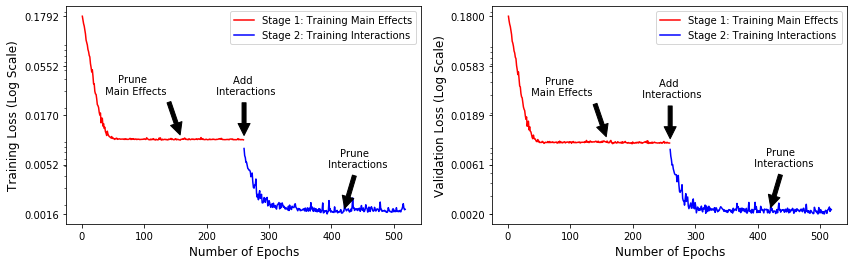

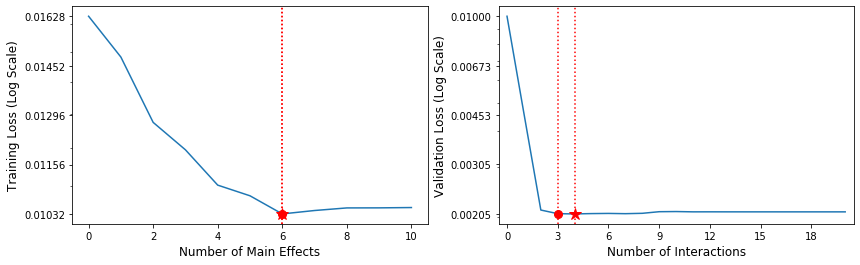

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

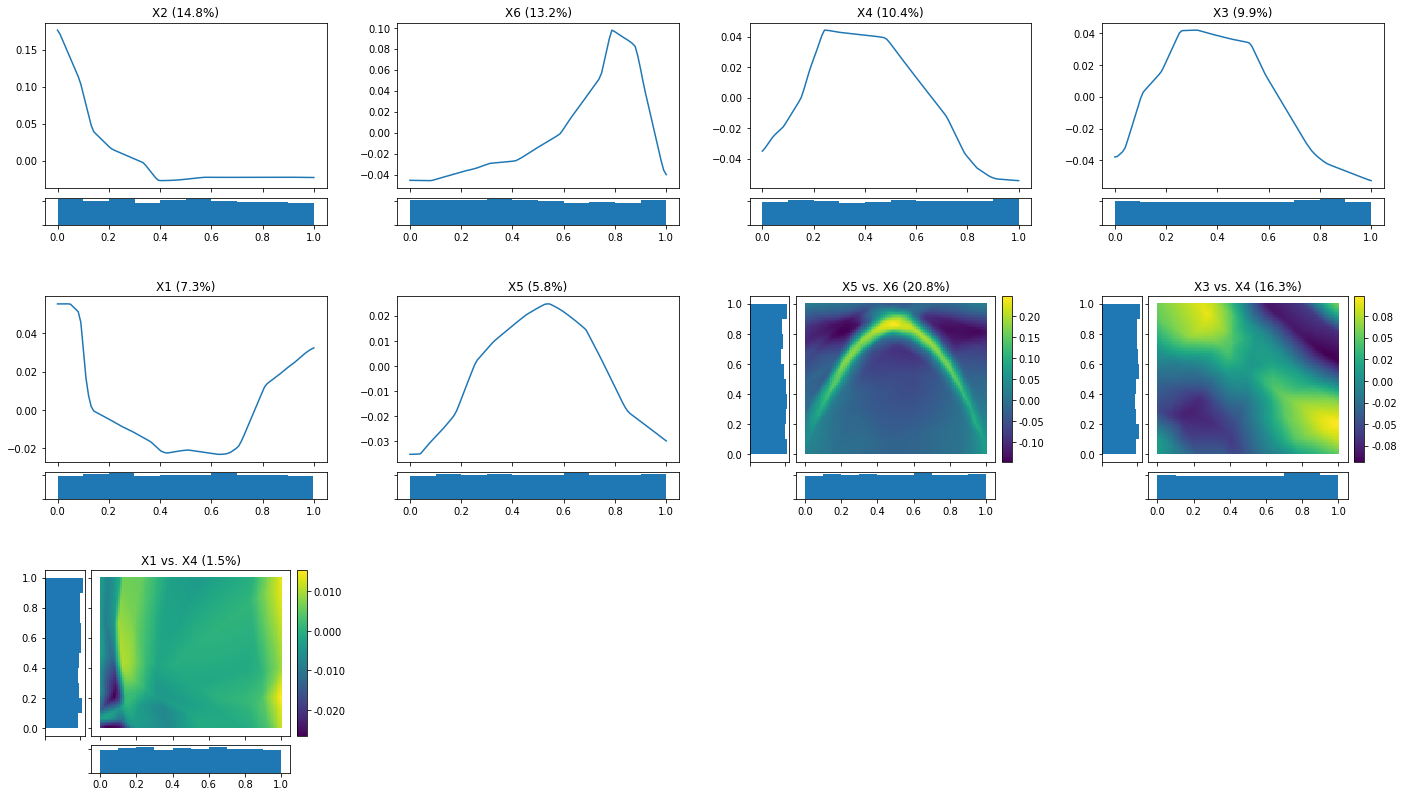

In [6]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')